![](img/330-banner.png)

# Lecture 20: Time series

UBC 2022-23

Instructor: Varada Kolhatkar

## Imports, announcements, LO

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

plt.rcParams["font.size"] = 12
from datetime import datetime

### Learning objectives

- Recognize when it is appropriate to use time series. 
- Explain the pitfalls of train/test splitting with time series data.
- Appropriately split time series data, both train/test split and cross-validation.
- Perform time series feature engineering:
  - Encode time as various features in a tabular dataset 
  - Create lag-based features
- Explain how can you forecast multiple time steps into the future.
- Explain the challenges of time series data with unequally spaced time points.
- At a high level, explain the concept of trend.

## Motivation

- **Time series** is a collection of data points indexed in time order. 
- Time series is everywhere:
    - Physical sciences (e.g., weather forecasting)  
    - Economics, finance (e.g., stocks, market trends)
    - Engineering (e.g., energy consumption)
    - Social sciences 
    - Sports analytics

Let's start with a simple example from [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/). 

In New York city there is a network of bike rental stations with a subscription system. The stations are all around the city. The anonymized data is available [here](https://ride.citibikenyc.com/system-data).

We will focus on the task is predicting how many people will rent a bicycle from a particular station for a given time and day. We might be interested in knowing this so that we know whether there will be any bikes left at the station for a particular day and time.  

In [ ]:
import mglearn

citibike = mglearn.datasets.load_citibike()
citibike.head()

- The only feature we have is the date time feature. 
    - Example: 2015-08-01 00:00:00
- The target is the number of rentals in the next 3 hours. 
    - Example: 3 rentals between 2015-08-01 00:00:00 and 2015-08-01 03:00:00

Let's check the time duration of our data. 

In [ ]:
citibike.index.min()

In [ ]:
citibike.index.max()

We have data for August 2015. 

In [ ]:
plt.figure(figsize=(8, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq="D")
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals");
plt.title("Number of bike rentals over time for a selected bike station");

- We see the day and night pattern
- We see the weekend and weekday pattern 

- Questions you might want to answer: How many people are likely to rent a bike at this station in the next three hours given everything we know about rentals in the past? 
- We want to learn from the past and predict the future. 

Can we use our usual machine learning methodology for this problem? 

### Train/test split for temporal data

- What will happen if we split this data the usual way?

In [ ]:
train_df, test_df = train_test_split(citibike, test_size=0.2, random_state=123)

In [ ]:
test_df.head()

In [ ]:
train_df.index.max()

In [ ]:
test_df.index.min()

- So, we are training on data that came after our test data!
- If we want to forecast, **we aren't allowed to know what happened in the future**!
- There may be cases where this is OK, e.g. if you aren't trying to forecast and just want to understand your data (maybe you're not even splitting).
- But, for our purposes, we want to avoid this.

In [ ]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

We'll split the data as follows:

- We have total 248 data points. 
- We'll use the fist 184 data points corresponding to the first 23 days as training data - And the remaining 64 data points corresponding to the remaining 8 days as test data. 

In [ ]:
citibike.shape

In [ ]:
n_train = 184
train_df = citibike[:184]
test_df = citibike[184:]

In [ ]:
plt.figure(figsize=(10, 3))
train_df_sort = train_df.sort_index()
test_df_sort = test_df.sort_index()

plt.plot(train_df_sort, "b", label="train")
plt.plot(test_df_sort, "r", label="test")
plt.xticks(rotation="vertical")
plt.legend();

- This split is looking reasonable now. 

<br><br>

### Training models 

- In this toy data, we just have a single feature: the date time feature. 
- We need to encode this feature if we want to build machine learning models. 
- A common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (this is beginning of Unix time). 
- Let's start with encoding this feature as a single integer representing this POSIX time. 

In [ ]:
X = (
    citibike.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
)  # convert to POSIX time by dividing by 10**9
y = citibike.values

In [ ]:
y_train = train_df.values
y_test = test_df.values
# convert to POSIX time by dividing by 10**9
X_train = train_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9
X_test = test_df.index.astype("int64").values.reshape(-1, 1) // 10 ** 9

In [ ]:
X_train[:10]

In [ ]:
y_train[:10]

- Our prediction task is a regression task. 

- Let's try random forest regression with just this feature. 
- We'll be trying out many different features. So we'll be using the function below which
    - Splits the data 
    - Trains the given regressor model on the training data
    - Shows train and test scores
    - Plots the predictions on the train and test data

In [ ]:
# Code credit: Adapted from 
# https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/

def eval_on_features(features, target, regressor, n_train = 184, sales_data=False, ylabel='Rentals'):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train)))
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    if not sales_data: 
        plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
        
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, "-", label="test")
    plt.plot(range(n_train), y_pred_train, "--", label="prediction train")

    plt.plot(
        range(n_train, len(y_test) + n_train), y_pred, "--", label="prediction test"
    )
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel(ylabel)

Let's try random forest regressor with our posix time feature. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

- The predictions on the training score is pretty good 
- But for the test data, a constant line is predicted ...
- What's going on? 

- The model is based on only one feature: POSIX time feature. 
- And the value of the POSIX time feature is outside the range of the feature values in the training set. 
- Tree-based models cannot _extrapolate_ to feature ranges outside the training data. 
- The model predicted the target value of the closest point in the training set. 

Can we come up with better features? 

### Feature engineering for date/time columns

- Note that our index is of this special type: [`DateTimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html). We can extract all kinds of interesting information from it.   

In [ ]:
citibike.index

In [ ]:
citibike.index.month_name()

In [ ]:
citibike.index.dayofweek

In [ ]:
citibike.index.day_name()

In [ ]:
citibike.index.hour

- We noted before that the time of the day and day of the week seem quite important. 
- Let's add these two features. 

Let's first add the time of the day. 

In [ ]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour[:10]

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor)

The scores are better when we add time of the day feature. 

Now let's add day of the week along with time of the day. 

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
X_hour_week = np.hstack(
    [
        citibike.index.dayofweek.values.reshape(-1, 1),
        citibike.index.hour.values.reshape(-1, 1),
    ]
)
eval_on_features(X_hour_week, y, regressor)

The results are much better. The time of the day and day of the week features are clearly helping. 

- Do we need a complex model such as a random forest? 
- Let's try `Ridge` with these features.

In [ ]:
from sklearn.linear_model import Ridge

lr = Ridge()
eval_on_features(X_hour_week, y, lr)

- Ridge is performing poorly on the training as well as test data.
- It's not able to capture the periodic pattern.
- The reason is that we have encoded time of day using integers. 
- A linear function can only learn a linear function of the time of day. 
- What if we encode this feature as a categorical variable? 

In [ ]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [ ]:
X_hour_week_onehot
X_hour_week_onehot.shape

In [ ]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour

In [ ]:
pd.DataFrame(X_hour_week_onehot, columns=features)

In [ ]:
eval_on_features(X_hour_week_onehot, y, Ridge())

- What if we add interaction features (e.g., something like Day == 5 and hour == 9:00)
- We can do it using `sklearn`'s `PolynomialFeatures` transformer. 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(
    interaction_only=True, include_bias=False
)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [ ]:
X_hour_week_onehot_poly.shape

In [ ]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features = day + hour
features

Let's examine the coefficients learned by `Ridge`. 

In [ ]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [ ]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

- The coefficients make sense!
- If it's Saturday 09:00 or Wednesday 06:00, the model is likely to predict bigger number for rentals. 
- If it's Midnight or 03:00 or Sunday 06:00, the model is likely to predict smaller number for rentals. 

<br><br>

## Lag-based features

- So far we engineered some features and managed to get reasonable results. 
- In time series data there is temporal dependence; observations close in time tend to be correlated. 
- Currently we're using current time to predict the number of bike rentals at that time. 
- But, what if the number of bike rentals is also related to bike rentals three hours ago or 6 hours ago and so on? 
  - Such features are called _lagged_ features.  
  
_Note: In time series analysis, you would look at something called an [autocorrelation function](https://en.wikipedia.org/wiki/Autocorrelation) (ACF), but we won't go into that here._ 

Let's extract lag features. We can "lag" (or "shift") a time series in Pandas with the `.shift()` method.

In [ ]:
citibike

In [ ]:
rentals_df = pd.DataFrame(citibike)
rentals_df = rentals_df.rename(columns={"one":"n_rentals"})
rentals_df

In [ ]:
def create_lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

In [ ]:
rentals_lag5 = create_lag_df(rentals_df, 5, ['n_rentals'] )

In [ ]:
rentals_lag5

- Note the NaN pattern. 
- We can either drop the first 5 rows or apply imputation. 
- Let's try these features with Ridge model. 

In [ ]:
X_lag_features = rentals_lag5.drop(columns = ['n_rentals']).to_numpy()

In [ ]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
lr = Ridge()
eval_on_features(X_lag_features_imp, y, lr)

The results are not great. But let's examine the coefficients. 

In [ ]:
features_lag = rentals_lag5.drop(columns=['n_rentals']).columns.tolist()
features_nonzero = np.array(features_lag)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

In [ ]:
pd.DataFrame(coef_nonzero, index=features_nonzero, columns=["Coefficient"]).sort_values(
    "Coefficient", ascending=False
)

How about `RandomForestRegressor` model? 

In [ ]:
imp = SimpleImputer()
X_lag_features_imp = imp.fit_transform(X_lag_features)
rf = RandomForestRegressor()
eval_on_features(X_lag_features_imp, y, rf)

The results are not as good as the results with our preciously engineered features. How about combining lag-based features and the previously extracted features? 

In [ ]:
X_hour_week_onehot_poly_lag = np.hstack([X_hour_week_onehot_poly, X_lag_features_imp])

In [ ]:
rf = RandomForestRegressor()
eval_on_features(X_hour_week_onehot_poly_lag, y, rf)

Some improvement but we are getting better results without the lag features in this case. 

### Cross-validation

What about cross-validation? 

- We can't do regular cross-validation if we don't want to be predicting the past.
- If you carry out regular cross-validation, you'll be predicting the past given future which is not a realistic scenario for the deployment data. 

In [ ]:
mglearn.plots.plot_cross_validation()

There is [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for time series data. 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Code from sklearn documentation
X_toy = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_toy = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X_toy):
    print("%s %s" % (train, test))

Let's try it out with Ridge on the bike rental data. 

In [ ]:
lr = Ridge()

In [ ]:
scores = cross_validate(
    lr, X_hour_week_onehot_poly, y, cv=TimeSeriesSplit(), return_train_score=True
)
pd.DataFrame(scores)

<br><br><br><br>

## Forecasting further into the future

Let's consider another time series dataset, [Retail Sales of Clothing and Clothing Accessory Stores dataset](https://fred.stlouisfed.org/series/MRTSSM448USN) which is made available by the Federal Reserve Bank of St. Louis.

The dataset has dates and retail sales values corresponding to the dates. 

In [ ]:
retail_df = pd.read_csv("data/MRTSSM448USN.csv", parse_dates=["DATE"])
retail_df.columns = ["date", "sales"]

In [ ]:
retail_df.head()

Let's examine the min and max dates in order to split the data. 

In [ ]:
retail_df["date"].min()

In [ ]:
retail_df["date"].max()

I'm considering everything upto 01 January 2016 as training data and everything after that as test data. 

In [ ]:
retail_df_train = retail_df.query("date <= 20160101")
retail_df_test = retail_df.query("date >  20160101")

In [ ]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

We can create a dataset using purely lag features.

In [ ]:
def lag_df(df, lag, cols):
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )

Let's create lag features for the full dataframe. 

In [ ]:
retail_lag_5 = lag_df(retail_df, 5, ["sales"])

In [ ]:
retail_train_5 = retail_lag_5.query("date <= 20160101")
retail_test_5 = retail_lag_5.query("date >  20160101")
retail_train_5

- Now, if we drop the "date" column we have a target ("sales") and 5 features (the previous 5 days of sales).
- We need to impute/drop the missing values and then we can fit a model to this. I will just drop for convenience:

In [ ]:
retail_train_5 = retail_train_5[5:].drop(columns=["date"])
retail_train_5

In [ ]:
retail_train_5_X = retail_train_5.drop(columns=["sales"])
retail_train_5_y = retail_train_5["sales"]

In [ ]:
retail_model = RandomForestRegressor(random_state=42)
retail_model.fit(retail_train_5_X, retail_train_5_y);
print("Train-set R^2: {:.2f}".format(retail_model.score(retail_train_5_X, retail_train_5_y)))

Given this, we can now predict the sales

In [ ]:
preds = retail_model.predict(retail_test_5.drop(columns=["date", "sales"]))
preds

In [ ]:
retail_test_5_preds = retail_test_5.assign(predicted_sales=preds)
retail_test_5_preds.tail()

- Ok, that is fine, but what if we want to predict 5 months in the future? 
- Well, we would not have access to our features!! We don't yet know the previous months sales, or two months prior! 

- There are a few approaches which could be employed:

1. Train a separate model for each number of months. E.g. one model that predicts sales for next month, another model that predicts sales in two months, etc. We can build these datasets.
2. Use a multi-output model that jointly predicts RainTomorrow, RainIn2Days, etc. However, multi-output models are outside the scope of CPSC 330. 
3. Use one model and sequentially predict using a `for` loop. However, this requires predicting _all_ features into a model so may not be that useful here.

If we decide to use approach 3, we would predict these values and then pretend they are true! For example, given that it's November 2022

1. Predict December 2022 sales
2. Then, to predict for January 2023, we need to know December 2022 sales. Use our _prediction_ for December 2022 as the truth.
3. Then, to predict for February 2023, we need to know December 2022 and January 2023 sales. Use our predictions.
4. Etc etc.

<br><br>

## Trends 

- There are some important concepts in time series that rely on having a continuous target (like we do in the retail sales example above).
- Part of that is the idea of seasonality and trends.
- These are mostly taken care of by our feature engineering of the data variable, but there's something important left to discuss.

In [ ]:
retail_df_train.plot(x="date", y="sales", figsize=(15, 5));

- It looks like there's a **trend** here - the sales are going up over time. 

Let's say we encoded the date as a feature in days like this:

In [ ]:
retail_train_5_date = retail_lag_5.query("date <= 20160101")
first_day_retail = retail_train_5_date["date"].min()

retail_train_5_date = retail_train_5_date.assign(
    Days_since=retail_train_5_date["date"].apply(lambda x: (x - first_day_retail).days)
)
retail_train_5_date.head(10)

- Now, let's say we use all these features (the lagged version of the target and also `Days_since`.
- If we use **linear regression** we'll learn a coefficient for `Days_since`. 
  - If that coefficient is positive, it predicts unlimited growth forever. That may not be what you want? It depends.
- If we use a **random forest**, we'll just be doing splits from the training set, e.g. "if `Days_since` > 9100 then do this".
  - There will be no splits for later time points because there is no training data there.
  - Thus tree-based models cannot model trends.
  - This is really important to know!!
- Often, we model the trend separately and use the random forest to model a de-trended time series.

<br><br><br><br>

## A more complicated dataset

[Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset. Predicting whether or not it will rain tomorrow based on today's measurements.

In [2]:
rain_df = pd.read_csv("data/weatherAUS.csv")
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
rain_df.shape

(145460, 23)

#### Goals

- Can the date/time features help us predict the target value?
- Can we **forecast** into the future? Can we predict whether it's going to rain tomorrow? 
- The target variable is `RainTomorrow`. The target is categorical and not continuous in this case. 

In [4]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
rain_df.describe(include="all")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


- A number of missing values. 
- Some target values are also missing. I'm dropping these rows. 

In [6]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

#### Parsing datetimes 

- In general, datetimes are a huge pain! 
    - Think of all the formats: MM-DD-YY, DD-MM-YY, YY-MM-DD, MM/DD/YY, DD/MM/YY, DD/MM/YYYY, 20:45, 8:45am, 8:45 PM, 8:45a, 08:00, 8:10:20, .......
  - Time zones.
  - Daylight savings...
- Thankfully, pandas does a pretty good job here.

In [7]:
dates_rain = pd.to_datetime(rain_df["Date"])
dates_rain

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 142193, dtype: datetime64[ns]

They are all the same format, so we can also compare dates:

In [8]:
dates_rain[1] - dates_rain[0]

Timedelta('1 days 00:00:00')

In [9]:
dates_rain[1] > dates_rain[0]

True

In [10]:
(dates_rain[1] - dates_rain[0]).total_seconds()

86400.0

We can also easily extract information from the date columns. 

In [11]:
dates_rain[1]

Timestamp('2008-12-02 00:00:00')

In [12]:
dates_rain[1].month_name()

'December'

In [13]:
dates_rain[1].day_name()

'Tuesday'

In [14]:
dates_rain[1].is_year_end

False

In [15]:
dates_rain[1].is_leap_year

True

Above pandas identified the date column automatically. You can tell pandas to parse the dates when reading in the CSV:

In [16]:
rain_df = pd.read_csv("data/weatherAUS.csv", parse_dates=["Date"])
rain_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [17]:
rain_df = rain_df[rain_df["RainTomorrow"].notna()]
rain_df.shape

(142193, 23)

In [18]:
rain_df["Date"].head()

0   2008-12-01
1   2008-12-02
2   2008-12-03
3   2008-12-04
4   2008-12-05
Name: Date, dtype: datetime64[ns]

## Train/test splits 

- Remember that we should not be calling the usual `train_test_split` with shuffling because 
- If we want to forecast, we aren't allowed to know what happened in the future!

In [19]:
rain_df["Date"].min()

Timestamp('2007-11-01 00:00:00')

In [20]:
rain_df["Date"].max()

Timestamp('2017-06-25 00:00:00')

- It looks like we have 10 years of data.
- Let's use the last 2 years for test.

In [21]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [22]:
len(train_df)

107502

In [23]:
len(test_df)

34691

In [24]:
len(test_df) / (len(train_df) + len(test_df))

0.24397122221206388

As we can see, we're still using about 25% of our data as test data.

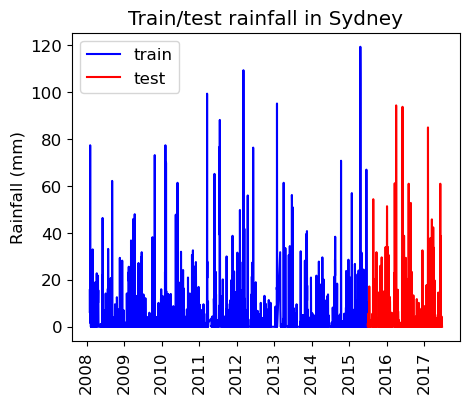

In [25]:
train_df_sort = train_df.query("Location == 'Sydney'").sort_values(by="Date")
test_df_sort = test_df.query("Location == 'Sydney'").sort_values(by="Date")

plt.figure(figsize=(5,4))
plt.plot(train_df_sort["Date"], train_df_sort["Rainfall"], "b", label="train")
plt.plot(test_df_sort["Date"], test_df_sort["Rainfall"], "r", label="test")
plt.xticks(rotation="vertical")
plt.legend()
plt.ylabel("Rainfall (mm)")
plt.title("Train/test rainfall in Sydney");

We're learning relationships from the blue part; predicting only using features in the red part from the day before.

Let's define a preprocessor with a column transformer. 

In [26]:
train_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107502 entries, 0 to 144733
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           107502 non-null  datetime64[ns]
 1   Location       107502 non-null  object        
 2   MinTemp        107050 non-null  float64       
 3   MaxTemp        107292 non-null  float64       
 4   Rainfall       106424 non-null  float64       
 5   Evaporation    66221 non-null   float64       
 6   Sunshine       62320 non-null   float64       
 7   WindGustDir    100103 non-null  object        
 8   WindGustSpeed  100146 non-null  float64       
 9   WindDir9am     99515 non-null   object        
 10  WindDir3pm     105314 non-null  object        
 11  WindSpeed9am   106322 non-null  float64       
 12  WindSpeed3pm   106319 non-null  float64       
 13  Humidity9am    106112 non-null  float64       
 14  Humidity3pm    106180 non-null  float64       
 15  

- We have missing data. 
- We have categorical features and numeric features. 

- Let's define feature types. 
- Let's start with dropping the date column and treating it as a usual supervised machine learning problem. 

In [28]:
numeric_features = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure9am",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "Temp9am",
    "Temp3pm",
]
categorical_features = [
    "Location",
    "WindGustDir",
    "WindDir9am",
    "WindDir3pm",
    "RainToday",
]
drop_features = ["Date"]
target = ["RainTomorrow"]

In [29]:
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df["RainTomorrow"]
    y_test = test_df["RainTomorrow"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [30]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features, target
)

In [31]:
X_train_enc.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_missing,RainToday_No,RainToday_Yes,RainToday_missing
0,0.204302,-0.027112,-0.205323,-0.140641,0.160729,0.298612,0.666166,0.599894,0.115428,-1.433514,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.741037,0.287031,-0.275008,-0.140641,0.160729,0.298612,-1.125617,0.373275,-1.314929,-1.288002,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.125523,0.372706,-0.275008,-0.140641,0.160729,0.450132,0.554180,0.826513,-1.632786,-1.045481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.457435,0.701128,-0.275008,-0.140641,0.160729,-1.216596,-0.341712,-1.099749,-1.261953,-1.724539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.850283,1.315134,-0.158867,-0.140641,0.160729,0.071330,-0.789657,0.146656,0.698167,-0.899969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### `DummyClassifier`

In [32]:
dc = DummyClassifier()
dc.fit(train_df, y_train);

In [33]:
dc.score(train_df, y_train)

0.7750553478074826

In [34]:
y_train.value_counts()

No     83320
Yes    24182
Name: RainTomorrow, dtype: int64

In [35]:
dc.score(test_df, y_test)

0.7781845435415525

### LogisticRegression

The function below trains a logistic regression model on the train set, reports train and test scores, and returns learned coefficients as a dataframe. 

In [36]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["logisticregression"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [37]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.243166
RainToday_missing,0.921010
Pressure9am,0.865415
Location_Witchcliffe,0.728813
WindGustSpeed,0.720426
...,...
RainToday_No,-0.720469
Location_Katherine,-0.726599
Location_Wollongong,-0.748939
Location_MountGinini,-0.965026


### Cross-validation

- We can carry out cross-validation using [`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split). 
- However, things are actually more complicated here because this dataset has **multiple time series**, one per location. 

In [38]:
train_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144729,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,73.0,37.0,1031.5,1027.6,NaN,NaN,8.8,17.2,No,No
144730,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,69.0,40.0,1029.9,1026.0,NaN,NaN,7.0,15.7,No,No
144731,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,69.0,39.0,1028.7,1025.0,NaN,3.0,8.9,18.0,No,No
144732,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,67.0,37.0,1027.2,1023.8,6.0,7.0,11.7,21.5,No,No


In [39]:
train_df.sort_values(by=["Date", "Location"]).head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No


In [40]:
train_df.sort_values(by=["Date"])

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,99.0,63.0,1029.5,1027.7,NaN,8.0,4.7,9.3,No,No
119911,2015-06-30,PerthAirport,10.1,23.5,0.0,3.2,5.8,NNE,31.0,NE,...,48.0,33.0,1023.6,1021.7,7.0,6.0,13.3,22.2,No,No
60455,2015-06-30,Bendigo,0.3,11.4,0.0,NaN,NaN,W,19.0,NaN,...,89.0,56.0,1029.3,1027.4,8.0,7.0,6.4,10.5,No,No
66473,2015-06-30,MelbourneAirport,3.2,13.2,0.0,0.8,3.9,N,20.0,N,...,91.0,50.0,1029.6,1027.3,2.0,7.0,5.3,11.9,No,No


- It seems the dataframe is sorted by location, and then time. 
- Our approach today will be to ignore the fact that we have multiple time series and just OHE the location
- We'll have multiple measurements for a given timestamp, and that's OK.
- But, `TimeSeriesSplit` expects the dataframe to be sorted by date so...

In [41]:
train_df_ordered = train_df.sort_values(by=["Date"])
y_train_ordered = train_df_ordered["RainTomorrow"]

In [42]:
train_df_ordered

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,68.0,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,80.0,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,82.0,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,62.0,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,68.0,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57415,2015-06-30,Ballarat,-0.3,10.5,0.0,NaN,NaN,S,26.0,NaN,...,99.0,63.0,1029.5,1027.7,NaN,8.0,4.7,9.3,No,No
119911,2015-06-30,PerthAirport,10.1,23.5,0.0,3.2,5.8,NNE,31.0,NE,...,48.0,33.0,1023.6,1021.7,7.0,6.0,13.3,22.2,No,No
60455,2015-06-30,Bendigo,0.3,11.4,0.0,NaN,NaN,W,19.0,NaN,...,89.0,56.0,1029.3,1027.4,8.0,7.0,6.4,10.5,No,No
66473,2015-06-30,MelbourneAirport,3.2,13.2,0.0,0.8,3.9,N,20.0,N,...,91.0,50.0,1029.6,1027.3,2.0,7.0,5.3,11.9,No,No


In [43]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
cross_val_score(lr_pipe, train_df_ordered, y_train_ordered, cv=TimeSeriesSplit()).mean()

0.8478763185801196

### Encoding date/time as feature(s)

- Can we use the `Date` to help us predict the target?
- Probably! E.g. different amounts of rain in different seasons.
- This is feature engineering!

### Encoding time as an number

- Idea 1: create a column of "days since Nov 1, 2007".

In [44]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [45]:
first_day = train_df["Date"].min()

train_df = train_df.assign(
    Days_since=train_df["Date"].apply(lambda x: (x - first_day).days)
)
test_df = test_df.assign(
    Days_since=test_df["Date"].apply(lambda x: (x - first_day).days)
)

In [46]:
train_df.sort_values(by="Date").head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Days_since
45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,...,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,0
45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,...,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,1
45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,...,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,2
45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,...,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,3
45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,...,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,4


In [47]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Days_since"],
    categorical_features,
    drop_features,
    target
)

In [48]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.243132
RainToday_missing,0.926886
Pressure9am,0.864083
Location_Witchcliffe,0.730503
WindGustSpeed,0.720199
...,...
Location_Townsville,-0.716830
Location_Katherine,-0.738088
Location_Wollongong,-0.746650
Location_MountGinini,-0.963987


- Not much improvement in the scores
- Can you think of other ways to generate features from the `Date` column? 
- What about the month - that seems relevant. How should we encode the month? 

Encode it as a categorical variable?

### One-hot encoding of the month

In [49]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [50]:
train_df = train_df.assign(
    Month=train_df["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = test_df.assign(Month=test_df["Date"].apply(lambda x: x.month_name()))

In [51]:
train_df[["Date", "Month"]].sort_values(by="Month")

,Date,Month
62657,2013-04-14,April
115089,2010-04-15,April
115090,2010-04-16,April
115091,2010-04-17,April
115092,2010-04-18,April
...,...,...
128828,2014-09-20,September
128829,2014-09-21,September
128830,2014-09-22,September
128820,2014-09-12,September


In [53]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)

In [54]:
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.84


,Coef
Humidity3pm,1.266895
RainToday_missing,0.942393
Pressure9am,0.799166
Location_Witchcliffe,0.749015
WindGustSpeed,0.705615
...,...
Location_Darwin,-0.736038
Location_Wollongong,-0.748122
Location_Townsville,-0.903197
Location_Katherine,-0.930516


In [63]:
train_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month', 'Season'],
      dtype='object')

No change in the results. 

### One-hot encoding seasons

How about just summer/winter as a feature?

In [55]:
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [56]:
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

In [57]:
train_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,December,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,December,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,December,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,December,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,December,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144729,2015-06-26,Uluru,3.8,18.3,0.0,NaN,NaN,E,39.0,ESE,...,1031.5,1027.6,NaN,NaN,8.8,17.2,No,No,June,Winter
144730,2015-06-27,Uluru,2.5,17.1,0.0,NaN,NaN,E,41.0,ESE,...,1029.9,1026.0,NaN,NaN,7.0,15.7,No,No,June,Winter
144731,2015-06-28,Uluru,4.5,19.6,0.0,NaN,NaN,ENE,35.0,ESE,...,1028.7,1025.0,NaN,3.0,8.9,18.0,No,No,June,Winter
144732,2015-06-29,Uluru,7.6,22.0,0.0,NaN,NaN,ESE,33.0,SE,...,1027.2,1023.8,6.0,7.0,11.7,21.5,No,No,June,Winter


In [58]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features + ["Season"],
    drop_features + ["Month"],
    target
)

In [59]:
X_train_enc.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'WindDir3pm_missing',
       'RainToday_No', 'RainToday_Yes', 'RainToday_missing', 'Season_Autumn',
       'Season_Fall', 'Season_Summer', 'Season_Winter'],
      dtype='object', length=123)

In [60]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [61]:
coeff_df.loc[["Season_Fall", "Season_Summer", "Season_Winter", "Season_Autumn"]]

,Coef
Season_Fall,0.067068
Season_Summer,-0.222156
Season_Winter,0.108548
Season_Autumn,0.048279


- No improvements in the scores but the coefficients make some sense,
- A negative coefficient for summer and a positive coefficients for winter. 

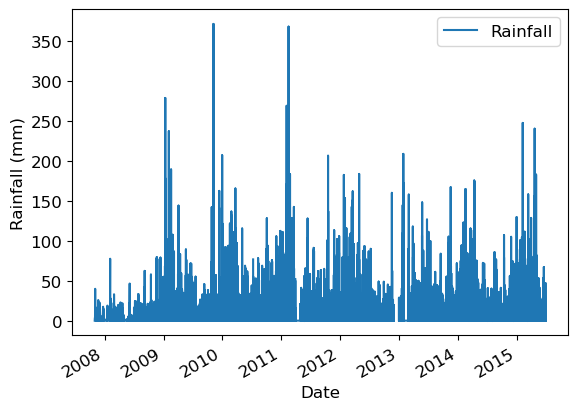

In [64]:
train_df.plot(x="Date", y="Rainfall")
plt.ylabel("Rainfall (mm)");

### Lag-based features

In [65]:
train_df = rain_df.query("Date <= 20150630")
test_df = rain_df.query("Date >  20150630")

In [66]:
train_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


- It looks like the dataframe is already sorted by Location and then by date for each Location.
- We could have done this ourselves with: 

In [67]:
# train_df.sort_values(by=["Location", "Date"])

But make sure to also sort the targets (i.e. do this before preprocessing).

We can "lag" (or "shift") a time series in Pandas with the .shift() method. 

In [70]:
train_df = train_df.assign(Rainfall_lag1=train_df["Rainfall"].shift(1))

In [71]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][:20]

,Date,Location,Rainfall,Rainfall_lag1
0,2008-12-01,Albury,0.6,NaN
1,2008-12-02,Albury,0.0,0.6
2,2008-12-03,Albury,0.0,0.0
3,2008-12-04,Albury,0.0,0.0
4,2008-12-05,Albury,1.0,0.0
5,2008-12-06,Albury,0.2,1.0
6,2008-12-07,Albury,0.0,0.2
7,2008-12-08,Albury,0.0,0.0
8,2008-12-09,Albury,0.0,0.0
9,2008-12-10,Albury,1.4,0.0


- But we have multiple time series here and we need to be more careful with this. 
- When we switch from one location to another we do not want to take the value from the previous location. 

In [72]:
def create_lag_feature(df, orig_feature, lag):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int."""
    # note: pandas .shift() kind of does this for you already, but oh well I already wrote this code

    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    for location, df_location in new_df.groupby(
        "Location"
    ):  # Each location is its own time series
        new_df.loc[df_location.index[lag:], new_feature_name] = df_location.iloc[:-lag][
            orig_feature
        ].values
    return new_df

In [73]:
train_df = create_lag_feature(train_df, "Rainfall", 1)

In [74]:
train_df[["Date", "Location", "Rainfall", "Rainfall_lag1"]][2285:2295]

,Date,Location,Rainfall,Rainfall_lag1
2309,2015-06-26,Albury,0.2,1.0
2310,2015-06-27,Albury,0.0,0.2
2311,2015-06-28,Albury,0.2,0.0
2312,2015-06-29,Albury,0.0,0.2
2313,2015-06-30,Albury,0.0,0.0
3040,2009-01-01,BadgerysCreek,0.0,NaN
3041,2009-01-02,BadgerysCreek,0.0,0.0
3042,2009-01-03,BadgerysCreek,0.0,0.0
3043,2009-01-04,BadgerysCreek,0.0,0.0
3044,2009-01-05,BadgerysCreek,0.0,0.0


Now it looks good! 

- Question: is it OK to do this to the test set? Discuss.
- It's fine if you would have this information available in deployment.
- If we're just forecasting the next day, we should.
- Let's include it for now.

In [75]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [76]:
rain_df_modified

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Rainfall_lag1
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,NaN
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.6
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [77]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["Rainfall_lag1"],
    categorical_features,
    drop_features,
    target
)

In [78]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

Train score: 0.85
Test score: 0.84


In [ ]:
lr_coef.loc[["Rainfall", "Rainfall_lag1"]]

- Rainfall from today has a positive coefficient. 
- Rainfall from yesterday has a positive but a smaller coefficient. 
- If we didn't have rainfall from today feature, rainfall from yesterday feature would have received a bigger coefficient.

- We could also create a lagged version of the target.
- In fact, this dataset already has that built in! `RainToday` is the lagged version of the target `RainTomorrow`.
- We could also create lagged version of other features, or more lags

In [ ]:
rain_df_modified = create_lag_feature(rain_df, "Rainfall", 1)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 2)
rain_df_modified = create_lag_feature(rain_df_modified, "Rainfall", 3)
rain_df_modified = create_lag_feature(rain_df_modified, "Humidity3pm", 1)

In [ ]:
rain_df_modified[
    [
        "Date",
        "Location",
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
].head(10)

Note the pattern of `NaN` values. 

In [ ]:
train_df = rain_df_modified.query("Date <= 20150630")
test_df = rain_df_modified.query("Date >  20150630")

In [ ]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features
    + ["Rainfall_lag1", "Rainfall_lag2", "Rainfall_lag3", "Humidity3pm_lag1"],
    categorical_features,
    drop_features,
    target
)

In [ ]:
lr_coef = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)

In [ ]:
lr_coef.loc[
    [
        "Rainfall",
        "Rainfall_lag1",
        "Rainfall_lag2",
        "Rainfall_lag3",
        "Humidity3pm",
        "Humidity3pm_lag1",
    ]
]

Note the pattern in the magnitude of the coefficients. 

<br><br><br><br>

## Final remarks 

What did we not cover?

- A huge amount!

### Traditional time series approaches

- Time series analysis is a huge field of its own (notice a pattern here?)
- Traditional approaches include the [ARIMA model](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and its various components/extensions.
- In Python, the [statsmodels](https://www.statsmodels.org/) package is the place to go for this sort of thing.
  - For example, [statsmodels.tsa.arima_model.ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html).
- These approaches can forecast, but they are also very good for understanding the temporal relationships in your data.
- We took different route in this course, and stick to our supervised learning tools.

### Deep learning 

- Recently, deep learning has been very successful too.
- In particular, [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs).
  - These are not covered in CPSC 340, but I believe they are in 540 (soon to be renamed 440).
  - [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) especially have shown a lot of promise in this type of task.
  - [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a blog post about LSTMs.

### Types of problems involving time series

- A single label associated with an entire time series. 
  - We had that with images earlier on, you could have the same for a time series.
  - E.g., for fraud detection, labelling each transaction as fraud/normal vs. labelling a person as bad/good based on their entire history.
  - There are various approaches that can be used for this type of problem, including CNNs (Lecture 19), LSTMs, and non deep learning methods.
- Inference problems
  - What are the patterns in this time series?
  - How many lags are associated with the current value?
  - Etc.

#### Unequally spaced time points

- We assumed we have a measurement each day.
- For example, when creating lag features we used consecutive rows in the DataFrame.
- But, in fact some days were missing in this dataset.
- More generally, what if the measurements are at arbitrary times, not equally spaced?
  - Some of our approaches would still work, like encoding the month.
  - Some of our approaches would not make sense, like the lags.
  - Perhaps the measurements could be binned into equally spaced bins, or something.
  - This is more of a hassle.

### Other software package

- A good one to know about is [Prophet](https://facebook.github.io/prophet/docs/quick_start.html).
- sktime
    - Time series classification
    - forecasting
- tslearn 
    - classification
    - regression
    - clustering

### Feature engineering

- Often, a useful approach is to just _engineer your own features_.
  - E.g., max expenditure, min expenditure, max-min, avg time gap between transactions, variance of time gap between transactions, etc etc.
  - We could do that here as well, or in any problem.
